In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sine_model import make_sin_data, LnLikelihood, LnPrior

import matplotlib.pyplot as plt
from tqdm import tqdm
import corner
from impulse import PTSampler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create the model and data to search through

In [3]:
x, data, omega_real, a_real, phi_real = make_sin_data(1000)

In [4]:
lnlike = LnLikelihood(x, data)
lnprior = LnPrior([0, 0, 0], [3, 5, np.pi])

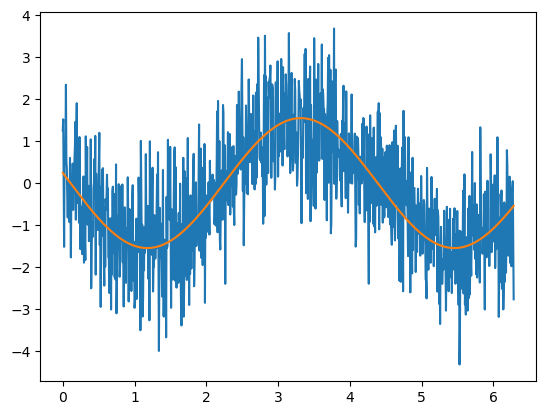

In [5]:
plt.plot(x, data)
plt.plot(x, a_real * np.sin(omega_real*x + phi_real))

## Do a grid approximation to compare with output of MCMC

In [6]:
num_points = 300
# grid approximate the posterior:
omega = np.linspace(0, 3, num_points)
a = np.linspace(0, 5, num_points)
phi = np.linspace(0, np.pi, num_points)

total = np.zeros((num_points, num_points, num_points))
for ii in tqdm(range(len(x))):
    total += -0.5 * (np.multiply.outer(a, np.sin(np.add.outer(np.multiply(omega, x[ii]), phi))) - data[ii])**2

100%|██████████| 1000/1000 [00:34<00:00, 29.17it/s]


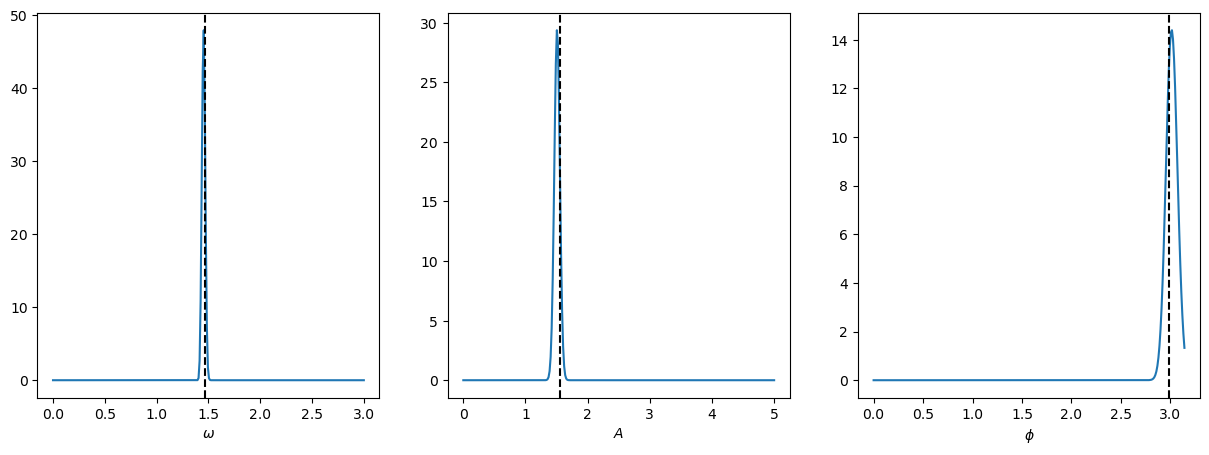

In [7]:
omega_post = np.sum(np.exp(total - np.max(total)), axis=(0, 2))
phi_post = np.sum(np.exp(total - np.max(total)), axis=(0, 1))
a_post = np.sum(np.exp(total - np.max(total)), axis=(1, 2))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(omega, omega_post)
ax[0].axvline(omega_real, color='k', linestyle='--')
ax[0].set_xlabel(r'$\omega$')

ax[1].plot(a, a_post)
ax[1].axvline(a_real, color='k', linestyle='--')
ax[1].set_xlabel(r'$A$')

ax[2].plot(phi, phi_post)
ax[2].axvline(phi_real, color='k', linestyle='--')
ax[2].set_xlabel(r'$\phi$')
plt.show()

## Sample!

In [9]:
# now sample it!
sampler = PTSampler(3, lnlike, lnprior, cov_update=100, ntemps=8, swap_steps=10, inf_temp=True)

In [10]:
sampler.sample(np.array([2, 3, 1]), 100_000, thin=1)

100%|██████████| 100000/100000 [00:33<00:00, 2983.49it/s]


## Check the autocorrelation length

In [11]:
from emcee.autocorr import integrated_time

In [13]:
chains = []
for ii in range(8):
    with open(f'/Users/aaron/Documents/GitHub/impulse_mcmc/examples/chains/chain_{ii}.txt') as fp:
        chains.append(np.loadtxt(fp))

In [14]:
integrated_time(chains[0][20000::1, 2])

array([8.3461741])

## Check the posteriors against the real values

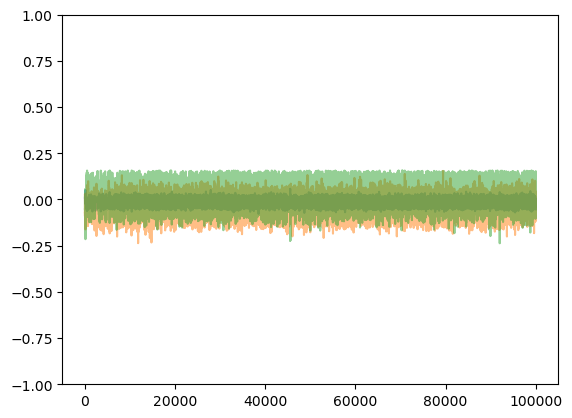

In [15]:
plt.plot(chains[0][:, 0] - omega_real, alpha = 0.5)
plt.plot(chains[0][:, 1] - a_real, alpha = 0.5)
plt.plot(chains[0][:, 2] - phi_real, alpha = 0.5)
plt.ylim([-1, 1]);

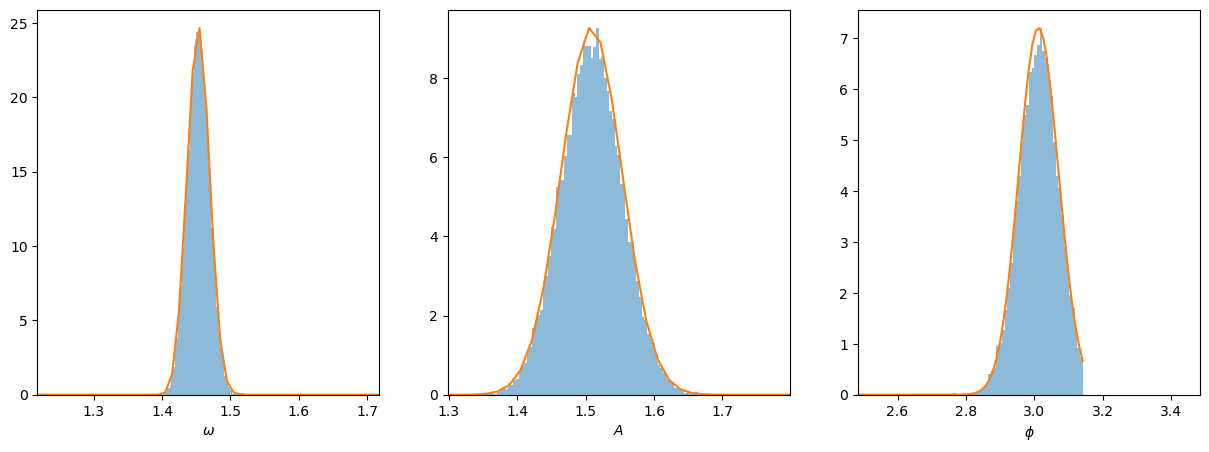

In [21]:
chain_idx = 0
temp = sampler.ptstate.ladder[chain_idx]

omega_post = np.sum(np.exp(1 / temp * (total - np.max(total))), axis=(0, 2))
phi_post = np.sum(np.exp(1 / temp * (total - np.max(total))), axis=(0, 1))
a_post = np.sum(np.exp(1 / temp * (total - np.max(total))), axis=(1, 2))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
counts, bins, __ = ax[0].hist(chains[chain_idx][:, 0], alpha=0.5, bins=70, density=True)
ax[0].plot(omega, omega_post / np.max(omega_post) * np.max(counts))
ax[0].set_xlim(([omega_real - 0.25, omega_real + 0.25]))
ax[0].set_xlabel(r'$\omega$')

counts, bins, __ = ax[1].hist(chains[chain_idx][:, 1], alpha=0.5, bins=100, density=True)
ax[1].plot(a, a_post / np.max(a_post) * np.max(counts))
ax[1].set_xlim(([a_real - 0.25, a_real + 0.25]))
ax[1].set_xlabel(r'$A$')

counts, bins, __ = ax[2].hist(chains[chain_idx][:, 2], alpha=0.5, bins=50, density=True)
ax[2].plot(phi, phi_post / np.max(phi_post) * np.max(counts))
ax[2].set_xlim(([phi_real - 0.5, phi_real + 0.5]))
ax[2].set_xlabel(r'$\phi$')
plt.show()

## Assess the parallel tempering 

(1.2, 1.8)

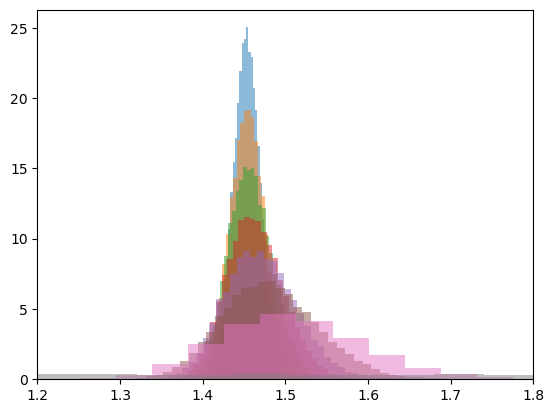

In [29]:
counts, bins, __ = plt.hist(chains[0][:, 0], alpha=0.5, bins=50, density=True);
plt.hist(chains[1][:, 0], alpha=0.5, bins=50, density=True);
plt.hist(chains[2][:, 0], alpha=0.5, bins=50, density=True);
plt.hist(chains[3][:, 0], alpha=0.5, bins=50, density=True);
plt.hist(chains[4][:, 0], alpha=0.5, bins=50, density=True);
plt.hist(chains[5][:, 0], alpha=0.5, bins=50, density=True);
plt.hist(chains[6][:, 0], alpha=0.5, bins=50, density=True);
plt.hist(chains[7][:, 0], alpha=0.5, bins=50, density=True);
plt.xlim(1.2, 1.8)
# plt.xlim(0, 1);

## Finally, make a corner plot

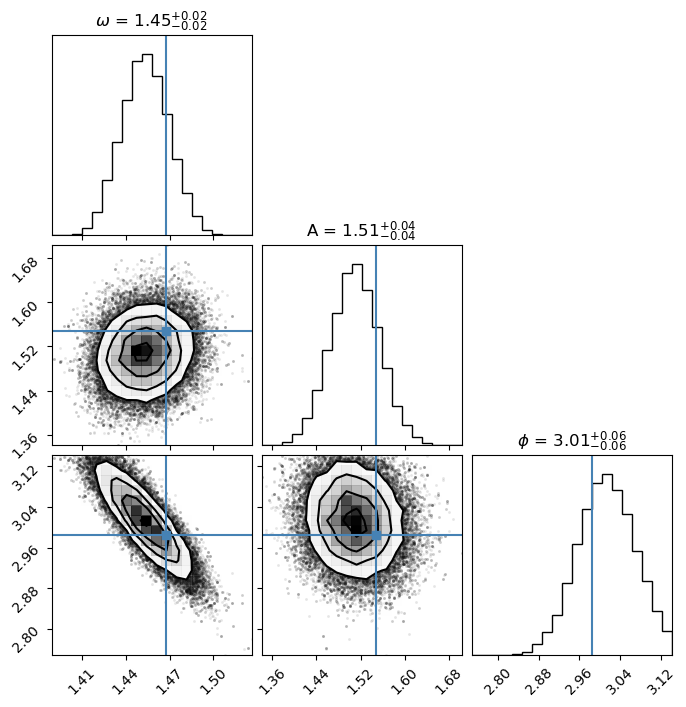

In [30]:
burn = 20_000

corner.corner(chains[0][burn::1, :3], truths=[omega_real, a_real, phi_real],
              titles=[r'$\omega$', r'A', r'$\phi$'], show_titles=True)
plt.show()